# Load stuff

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AffinityPropagation
import colorsys
%matplotlib inline

Create output folders

In [2]:
import os
if not os.path.exists('figures'):
    os.mkdir('figures')
if not os.path.exists('results'):
    os.mkdir('results')

# Functions

In [3]:
def hexencode(rgb):
    """Transform an RGB tuple to a hex string (html color)"""
    r=int(rgb[0])
    g=int(rgb[1])
    b=int(rgb[2])
    return '#%02x%02x%02x' % (r,g,b)

# Simple test

![palette](img/color_palettes_23_0.png)

In [4]:
im = Image.open('img/color_palettes_23_0.png')  # Taken from: http://seaborn.pydata.org/tutorial/color_palettes.html
w, h = im.size
colors = im.getcolors(w*h)

In [5]:
# Check that the sum of colors match the number of pixels
assert sum([colors[i][0] for i in range(len(colors))]) == w*h

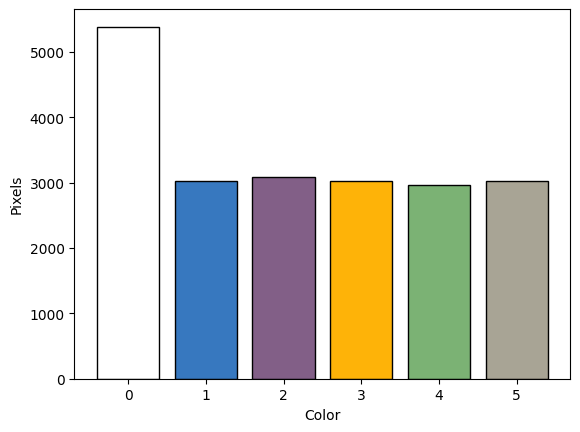

In [6]:
for idx, c in enumerate(colors):
    plt.bar(idx, c[0], color=hexencode(c[1]), lw=1, ec='k')
plt.ylabel('Pixels')
plt.xlabel('Color')
plt.savefig('figures/color-hist.png', bbox_inches='tight')

# Bricks

## Load image and create histogram

In [7]:
# im = Image.open('img/bricks.png')
im = Image.open('img/bricks-scaled.png')
w, h = im.size
colors = im.getcolors(w*h)

![bricks](img/bricks-scaled.png)

In [8]:
# Check that the sum of colors match the number of pixels
assert sum([colors[i][0] for i in range(len(colors))]) == w*h

The cell below takes a long time to run and is not needed for the remaining code to run.

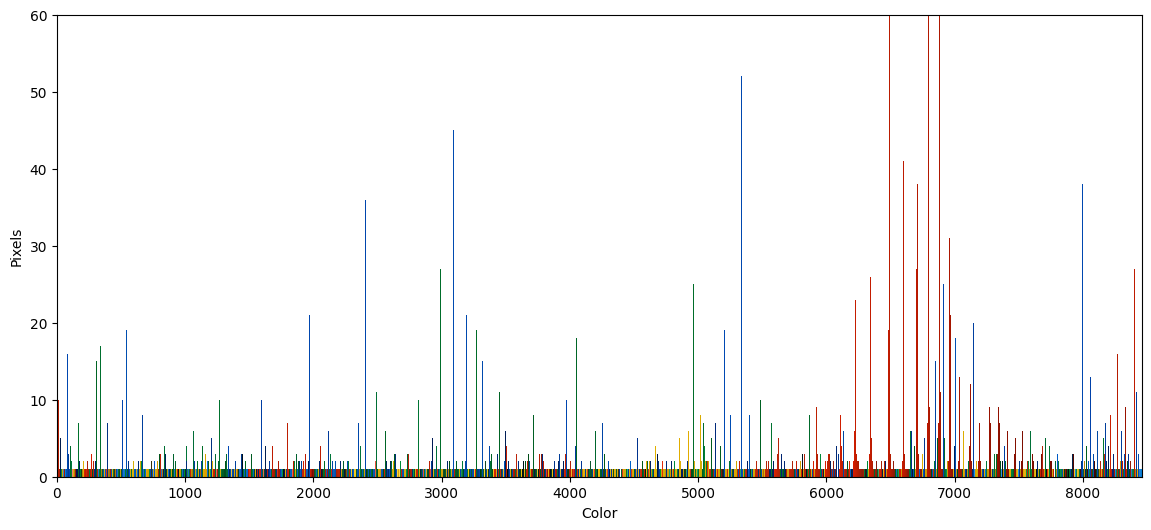

In [9]:
plt.figure(figsize=(14,6))
for idx, c in enumerate(colors):
    plt.bar(idx, c[0], color=hexencode(c[1]), lw=0, width=1)
plt.axis([0, len(colors), 0, 60])
plt.ylabel('Pixels')
plt.xlabel('Color')
plt.savefig('figures/color-hist-2.png', bbox_inches='tight')

## Plot individual colors

In [10]:
df = pd.DataFrame(
    data={
        'pixels': [colors[i][0] for i in range(len(colors))],
        'R': [colors[i][1][0] for i in range(len(colors))],
        'G': [colors[i][1][1] for i in range(len(colors))],
        'B': [colors[i][1][2] for i in range(len(colors))],
        'alpha': [colors[i][1][3] for i in range(len(colors))],
        'hex': [hexencode(colors[i][1]) for i in range(len(colors))]
    })

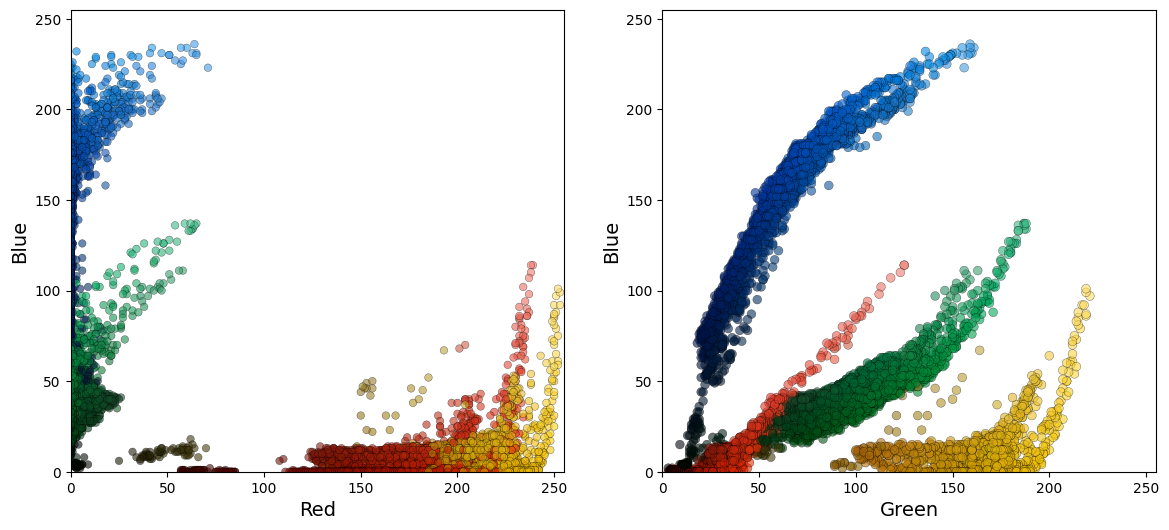

In [11]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.scatter(x=df.R, y=df.B, s=30, c=df.hex, alpha=.6, edgecolor='k', lw=0.3)
plt.axis([0, 255, 0, 255])
plt.xlabel('Red', fontsize=14)
plt.ylabel('Blue', fontsize=14)
plt.subplot(122)
plt.scatter(x=df.G, y=df.B, s=40, c=df.hex, alpha=.6, edgecolor='k', lw=0.3)
plt.axis([0, 255, 0, 255])
plt.xlabel('Green', fontsize=14)
plt.ylabel('Blue', fontsize=14)
plt.savefig('figures/rgb-proj.png', bbox_inches='tight')

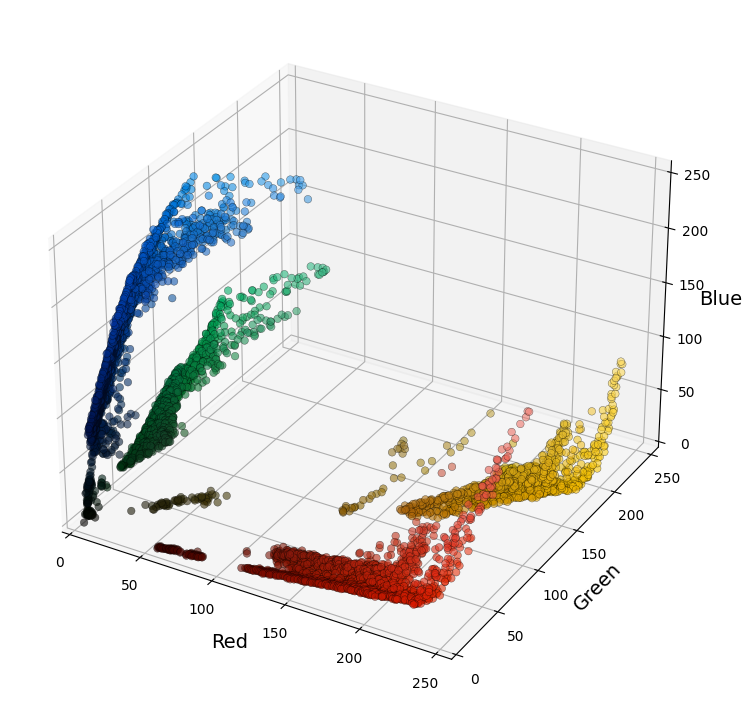

In [12]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = df.R
y = df.G
z = df.B
c = df.hex
s = 30

ax.scatter(x, y, z, c=c, s=s, alpha=.6, edgecolor='k', lw=0.3)

ax.set_xlim3d(0, 255)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 255)

ax.set_xlabel('Red', fontsize=14)
ax.set_ylabel('Green', fontsize=14)
ax.set_zlabel('Blue', fontsize=14)
plt.savefig('figures/rgb-scatter.png', bbox_inches='tight')

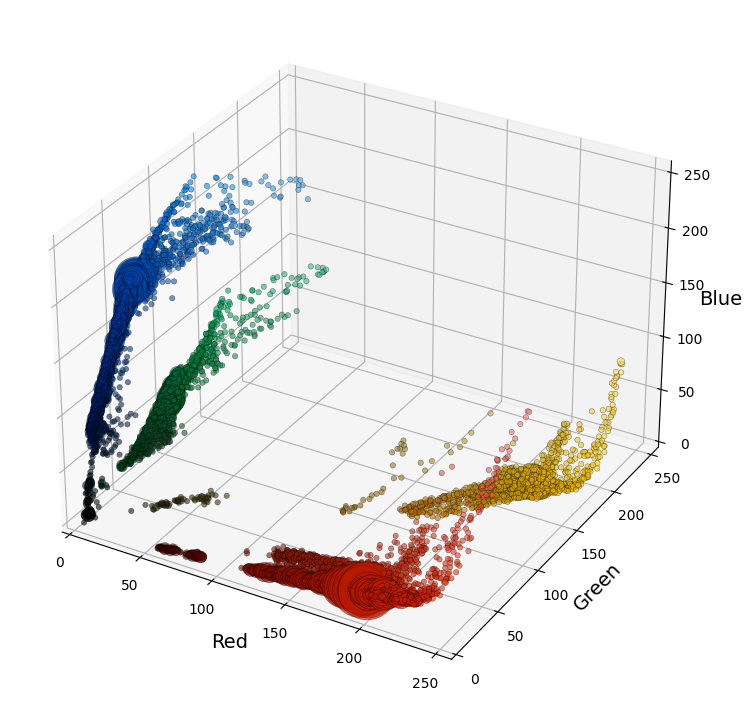

In [13]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = df.R
y = df.G
z = df.B
c = df.hex
s = df.pixels * 15

ax.scatter(x, y, z, c=c, s=s, alpha=.6, edgecolor='k', lw=0.3)

ax.set_xlim3d(0, 255)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 255)

ax.set_xlabel('Red', fontsize=14)
ax.set_ylabel('Green', fontsize=14)
ax.set_zlabel('Blue', fontsize=14)
plt.savefig('figures/rgb-scatter2.png', bbox_inches='tight')

## RGB k-means

In [14]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df[['R', 'G', 'B']])

In [15]:
df['kcenter'] = kmeans.labels_

Calculate weighted average of RBG color

In [16]:
avg_col = np.zeros((kmeans.n_clusters, 3))
for c in range(kmeans.n_clusters):
    temp_df = df[df.kcenter == c]
    avg_col[c, 0] = np.average(temp_df.R, weights=temp_df.pixels)
    avg_col[c, 1] = np.average(temp_df.B, weights=temp_df.pixels)
    avg_col[c, 2] = np.average(temp_df.G, weights=temp_df.pixels)

Calculate weighted average of HSV color

In [17]:
hsv_matrix = np.zeros((len(df), 3))

for i in range(len(df)):
    hsv_matrix[i] = colorsys.rgb_to_hsv(r=df.R[i]/255, g=df.G[i]/255, b=df.B[i]/255)
    
df['h'] = hsv_matrix[:, 0]
df['s'] = hsv_matrix[:, 1]
df['v'] = hsv_matrix[:, 2]

avg_col2 = np.zeros((kmeans.n_clusters, 3))
for c in range(kmeans.n_clusters):
    temp_df = df[df.kcenter == c]
    avg_col2[c, 0], avg_col2[c, 1], avg_col2[c, 2] = colorsys.hsv_to_rgb(h=np.average(temp_df.h, weights=temp_df.pixels),
                                                                         s=np.average(temp_df.s, weights=temp_df.pixels),
                                                                         v=np.average(temp_df.v, weights=temp_df.pixels))
avg_col2 *= 255

Text(0.5, 0.92, 'Weighted average HSV')

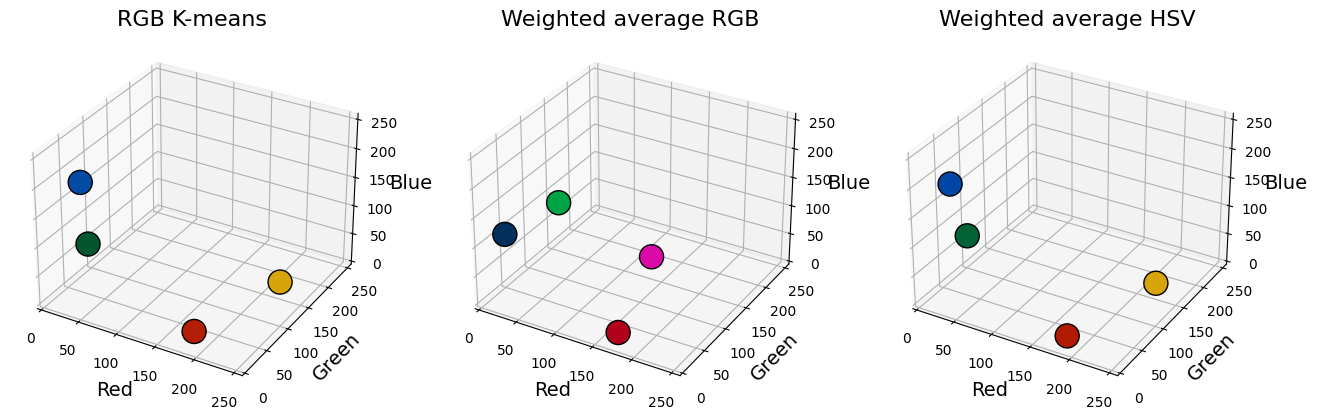

In [18]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131, projection='3d')

x = kmeans.cluster_centers_[:, 0]
y = kmeans.cluster_centers_[:, 1]
z = kmeans.cluster_centers_[:, 2]
c = [hexencode(kmeans.cluster_centers_[i,:]) for i in range(kmeans.n_clusters)]
s = 300

ax.scatter(x, y, z, c=c, s=s, alpha=1, edgecolor='k', lw=1)

ax.set_xlim3d(0, 255)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 255)
ax.set_xlabel('Red', fontsize=14)
ax.set_ylabel('Green', fontsize=14)
ax.set_zlabel('Blue', fontsize=14)
ax.set_title('RGB K-means', fontsize=16)


ax = fig.add_subplot(132, projection='3d')
x = avg_col[:, 0]
y = avg_col[:, 1]
z = avg_col[:, 2]
c = [hexencode(r) for r in avg_col]
s = 300

ax.scatter(x, y, z, c=c, s=s, alpha=1, edgecolor='k', lw=1)

ax.set_xlim3d(0, 255)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 255)
ax.set_xlabel('Red', fontsize=14)
ax.set_ylabel('Green', fontsize=14)
ax.set_zlabel('Blue', fontsize=14)
ax.set_title('Weighted average RGB', fontsize=16)


ax = fig.add_subplot(133, projection='3d')
x = avg_col2[:, 0]
y = avg_col2[:, 1]
z = avg_col2[:, 2]
c = [hexencode(r) for r in avg_col2]
s = 300

ax.scatter(x, y, z, c=c, s=s, alpha=1, edgecolor='k', lw=1)

ax.set_xlim3d(0, 255)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 255)
ax.set_xlabel('Red', fontsize=14)
ax.set_ylabel('Green', fontsize=14)
ax.set_zlabel('Blue', fontsize=14)
ax.set_title('Weighted average HSV', fontsize=16)

Text(0.5, 0, 'Blue')

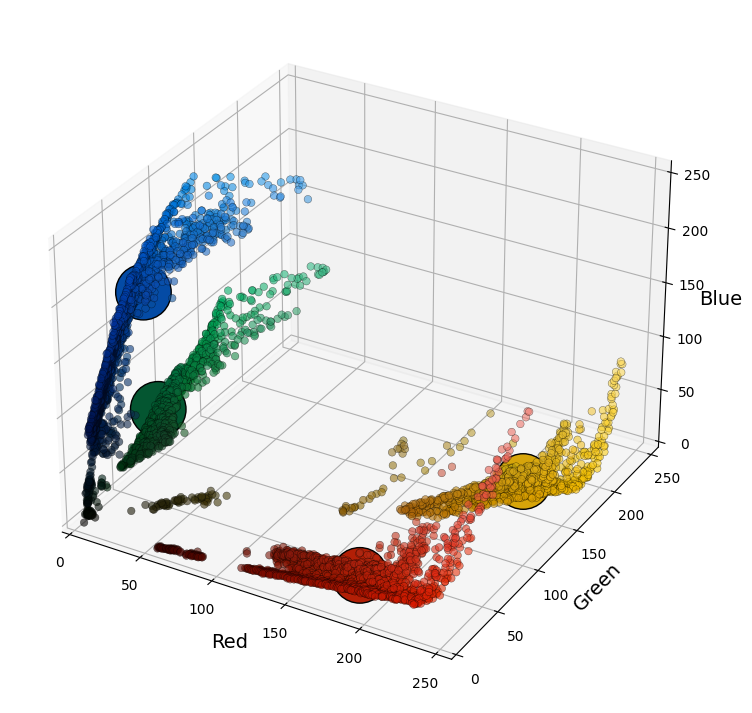

In [19]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = df.R
y = df.G
z = df.B
c = df.hex
s = 30
ax.scatter(x, y, z, c=c, s=s, alpha=.6, edgecolor='k', lw=0.3)


x = kmeans.cluster_centers_[:, 0]
y = kmeans.cluster_centers_[:, 1]
z = kmeans.cluster_centers_[:, 2]
c = [hexencode(kmeans.cluster_centers_[i,:]) for i in range(kmeans.n_clusters)]
s = 1600
ax.scatter(x, y, z, c=c, s=s, alpha=1, edgecolor='k', lw=1, marker='o')

ax.set_xlim3d(0, 255)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 255)

ax.set_xlabel('Red', fontsize=14)
ax.set_ylabel('Green', fontsize=14)
ax.set_zlabel('Blue', fontsize=14)

## HSV k-means

In [20]:
kmeansHSV = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df[['h', 's', 'v']])

In [21]:
dfHSV = df.copy()
dfHSV['kcenter'] = kmeansHSV.labels_

In [22]:
HSVcenters = np.zeros((kmeansHSV.n_clusters, 3))
for i in range(kmeansHSV.n_clusters):
    HSVcenters[i, :] = colorsys.hsv_to_rgb(h=kmeansHSV.cluster_centers_[i, 0],
                                           s=kmeansHSV.cluster_centers_[i, 1],
                                           v=kmeansHSV.cluster_centers_[i, 2])
HSVcenters *= 255

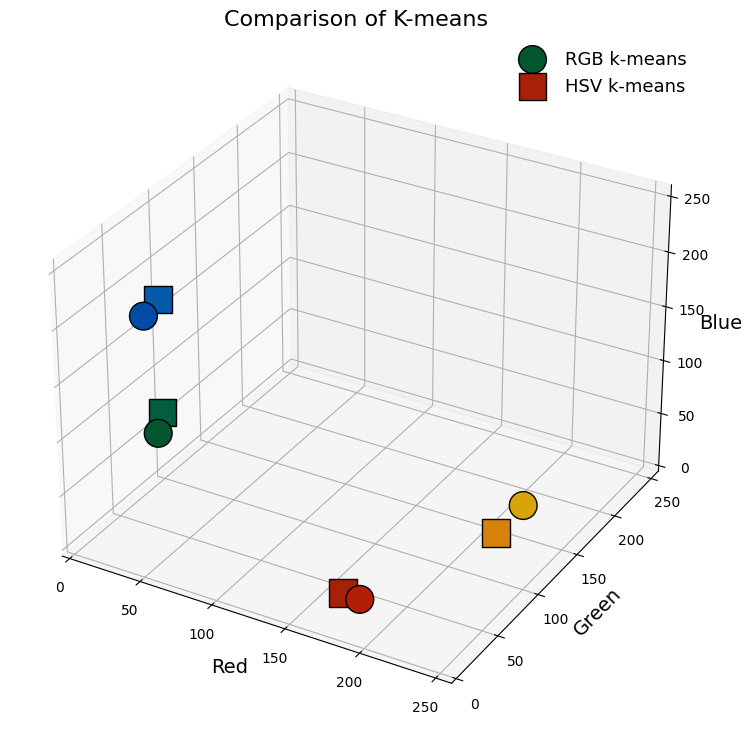

In [23]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = kmeans.cluster_centers_[:, 0]
y = kmeans.cluster_centers_[:, 1]
z = kmeans.cluster_centers_[:, 2]
c = [hexencode(kmeans.cluster_centers_[i,:]) for i in range(kmeans.n_clusters)]
s = 400

ax.scatter(x, y, z, c=c, s=s, alpha=1, edgecolor='k', lw=1)


x = HSVcenters[:, 0]
y = HSVcenters[:, 1]
z = HSVcenters[:, 2]
c = [hexencode(HSVcenters[i,:]) for i in range(kmeansHSV.n_clusters)]

ax.scatter(x, y, z, c=c, s=s, alpha=1, edgecolor='k', lw=1, marker='s')

ax.set_xlim3d(0, 255)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 255)
ax.set_xlabel('Red', fontsize=14)
ax.set_ylabel('Green', fontsize=14)
ax.set_zlabel('Blue', fontsize=14)
ax.set_title('Comparison of K-means', fontsize=16)
ax.legend(['RGB k-means', 'HSV k-means'], scatterpoints=1, frameon=False, fontsize=13)

## HSV plotting

Text(0.5, 0, 'V')

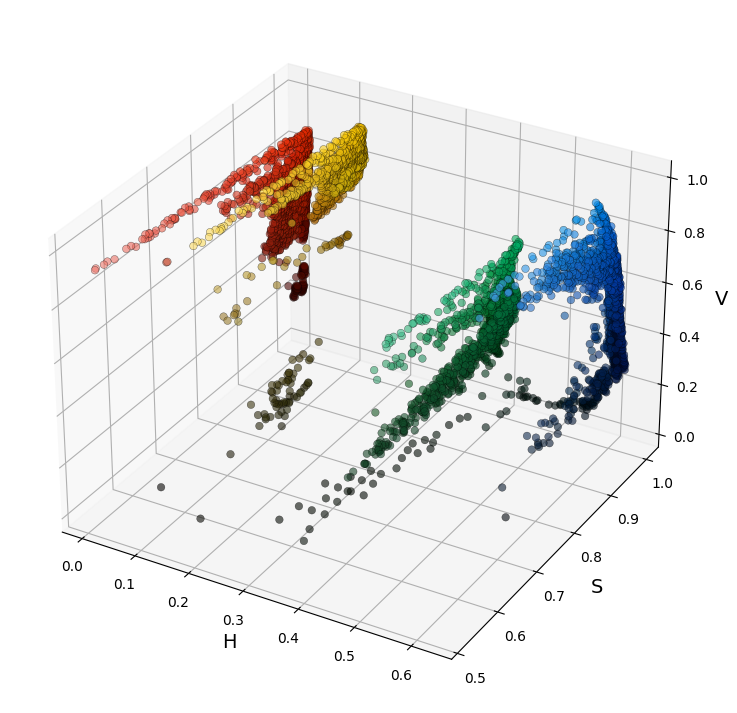

In [24]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = df.h
y = df.s
z = df.v
c = df.hex
s = 30

ax.scatter(x, y, z, c=c, s=s, alpha=.6, edgecolor='k', lw=0.3)

# ax.set_xlim3d(0, 255)
# ax.set_ylim3d(0, 255)
# ax.set_zlim3d(0, 255)

ax.set_xlabel('H', fontsize=14)
ax.set_ylabel('S', fontsize=14)
ax.set_zlabel('V', fontsize=14)

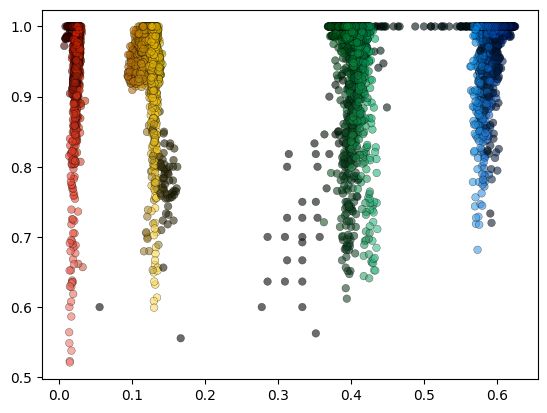

In [25]:
x = df.h
y = df.s
z = df.v
c = df.hex
s = 30

plt.scatter(x, y, c=c, s=s, alpha=.6, edgecolor='k', lw=0.3)


In [26]:
df[['h', 's', 'v']].describe()

,h,s,v
count,8460.000000,8460.000000,8460.000000
mean,0.287798,0.962644,0.621810
std,0.231578,0.062979,0.202658
min,0.007143,0.521008,0.019608
25%,0.026736,0.949495,0.450980
50%,0.371989,0.990566,0.670588
75%,0.576430,1.000000,0.788235
max,0.625000,1.000000,0.992157


### Circular plot of HSV

![HSV plot](http://www.tech-faq.com/wp-content/uploads/2009/02/hsv.jpeg)
http://www.tech-faq.com/hsv.html

In [27]:
circ_y = df.s*np.sin(df.h*2*np.pi)
circ_x = df.s*np.cos(df.h*2*np.pi)

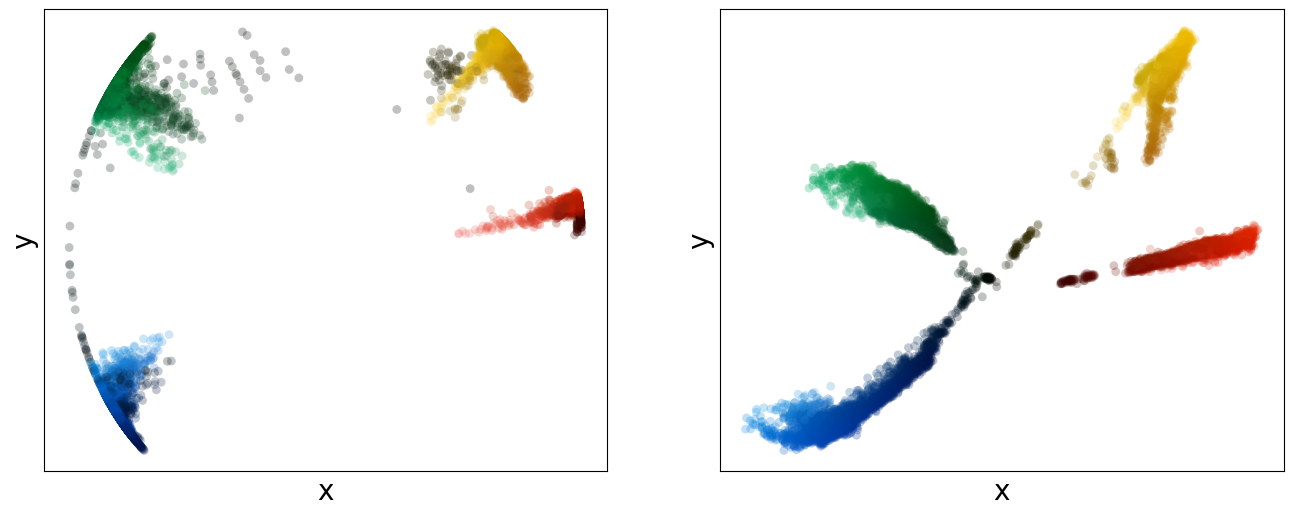

In [28]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121)
plt.scatter(circ_x, circ_y, s=40, alpha = .25, c=df.hex, lw=0)
ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False,
    left=False,
    labelleft=False)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)

ax = plt.subplot(122)
plt.scatter(df.v*circ_x, df.v*circ_y, s=40, alpha = .25, c=df.hex, lw=0)
ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False,
    left=False,
    labelleft=False)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)

plt.savefig('figures/hsv-proj.png', bbox_inches='tight')

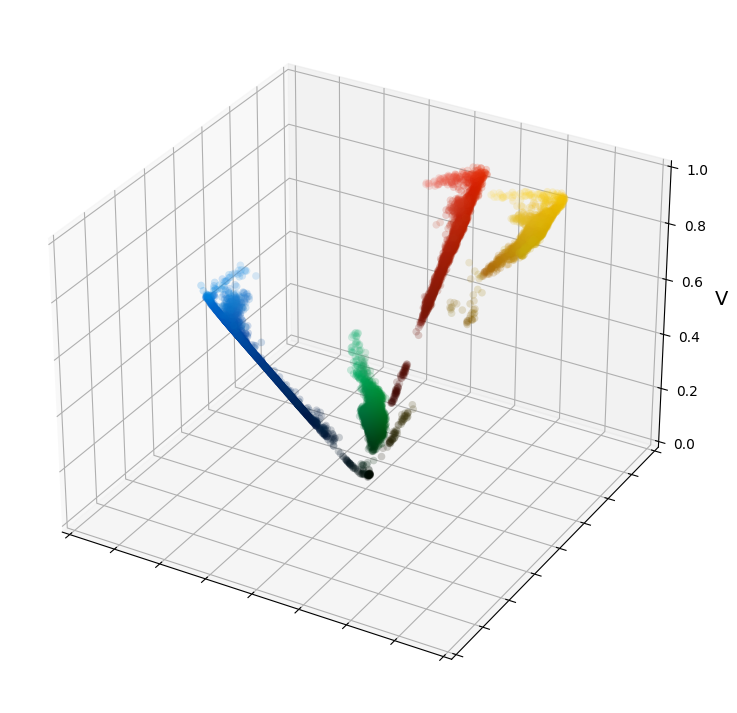

In [29]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = df.v*df.s*np.sin(df.h*2*np.pi)
y = df.v*df.s*np.cos(df.h*2*np.pi)
z = df.v
c = df.hex
s = 30

ax.scatter(x, y, z, c=c, s=s, alpha=.2, edgecolor='k', lw=0)

ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 1)

# ax.set_xlabel('H', fontsize=14)
# ax.set_ylabel('S', fontsize=14)
ax.set_zlabel('V', fontsize=14)

ax.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
ax.tick_params(
    axis='y',
    which='both',
    bottom=False,
    top=False,
    right=False,
    left=False,
    labelbottom=False,
    labelright=False,
    labelleft=False)

plt.savefig('figures/hsv-scatter.png', bbox_inches='tight')

In [30]:
cut = df[df.v > 0.40]

Text(0.5, 0, 'V')

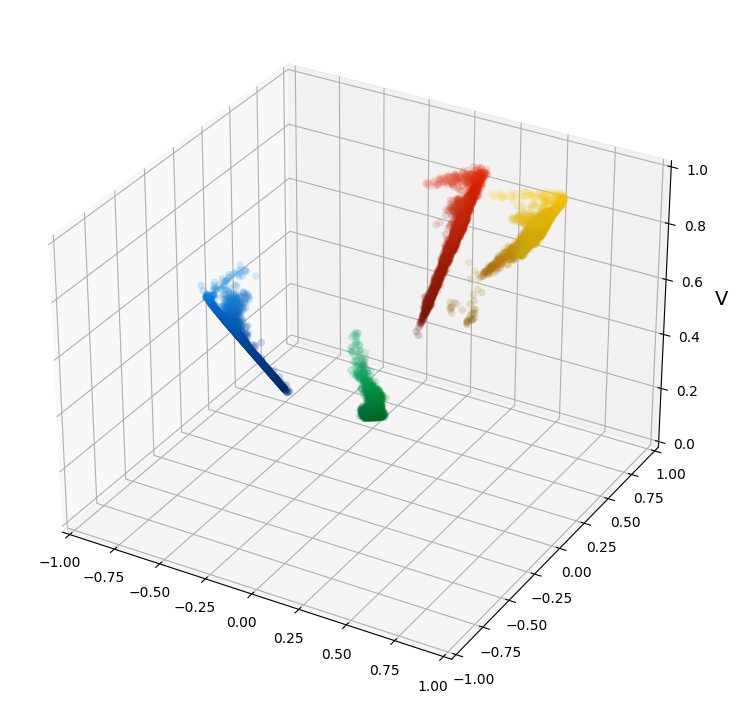

In [31]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = cut.v*cut.s*np.sin(cut.h*2*np.pi)
y = cut.v*cut.s*np.cos(cut.h*2*np.pi)
z = cut.v
c = cut.hex
s = 30

ax.scatter(x, y, z, c=c, s=s, alpha=.2, edgecolor='k', lw=0)

ax.set_xlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 1)

# ax.set_xlabel('H', fontsize=14)
# ax.set_ylabel('S', fontsize=14)
ax.set_zlabel('V', fontsize=14)

## Plotly plotting

In [32]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

ModuleNotFoundError: No module named 'plotly'

### RGB

Interactive plot of individual colors and cluster centers for RGB decomposition. Compare cluster centers with weighted average color within each cluster.

In [ ]:
weighted_cluster_centers = np.zeros((kmeans.n_clusters, 3))
for c in range(kmeans.n_clusters):
    weighted_cluster_centers[c] = np.average(df[df['kcenter'] == c][['R', 'G', 'B']], weights=df[df['kcenter'] == c]['pixels'], axis=0)

In [ ]:
x = df.R
y = df.G
z = df.B
c = df.hex

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=6,
        color=c,
        opacity=0.25),
    name='Individual colors')

x = kmeans.cluster_centers_[:, 0]
y = kmeans.cluster_centers_[:, 1]
z = kmeans.cluster_centers_[:, 2]
c = [hexencode(kmeans.cluster_centers_[i,:]) for i in range(kmeans.n_clusters)]

trace2 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=16,
        color=c,
        opacity=1),
    name='k-means center')

x = weighted_cluster_centers[:, 0]
y = weighted_cluster_centers[:, 1]
z = weighted_cluster_centers[:, 2]
c = [hexencode(kmeans.cluster_centers_[i,:]) for i in range(kmeans.n_clusters)]
trace3 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=16,
        color="#aa00aa",
        opacity=1),
    name='weighted center')

data = [trace1, trace2, trace3]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=data, layout=layout)
_ = iplot(fig)

### HSV

Interactive plot of individual colors and cluster centers for HSV decomposition. Compare cluster centers with weighted average color within each cluster.

In [ ]:
weighted_cluster_centers = np.zeros((kmeansHSV.n_clusters, 3))
for c in range(kmeansHSV.n_clusters):
    # weighted_cluster_centers[c] = dfHSV[dfHSV['kcenter'] == c].mean()[['h', 's', 'v']].values
    weighted_cluster_centers[c] = np.average(dfHSV[dfHSV['kcenter'] == c][['h', 's', 'v']], weights=dfHSV[dfHSV['kcenter'] == c]['pixels'], axis=0)

In [ ]:
weighted_cluster_center_colors = np.zeros((kmeansHSV.n_clusters, 3))
for i in range(kmeansHSV.n_clusters):
    weighted_cluster_center_colors[i] = colorsys.hsv_to_rgb(
        h=weighted_cluster_centers[i, 0],
        s=weighted_cluster_centers[i, 1],
        v=weighted_cluster_centers[i, 2])
weighted_cluster_center_colors *= 255

In [ ]:
x = dfHSV.v * dfHSV.s * np.sin(dfHSV.h * 2 * np.pi)
y = dfHSV.v * dfHSV.s * np.cos(dfHSV.h * 2 * np.pi)
z = dfHSV.v
c = dfHSV.hex

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=6,
        color=c,
        opacity=0.25),
    name='Individual colors')

x = kmeansHSV.cluster_centers_[:, 2] * kmeansHSV.cluster_centers_[:, 1] * np.sin(kmeansHSV.cluster_centers_[:, 0] * 2 * np.pi)
y = kmeansHSV.cluster_centers_[:, 2] * kmeansHSV.cluster_centers_[:, 1] * np.cos(kmeansHSV.cluster_centers_[:, 0] * 2 * np.pi)
z = kmeansHSV.cluster_centers_[:, 2]
c = [hexencode(HSVcenters[i,:]) for i in range(kmeansHSV.n_clusters)]

trace2 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=16,
        color=c,
        opacity=1),
    name='k-means center')

x = weighted_cluster_centers[:, 2] * weighted_cluster_centers[:, 1] * np.sin(weighted_cluster_centers[:, 0] * 2 * np.pi)
y = weighted_cluster_centers[:, 2] * weighted_cluster_centers[:, 1] * np.cos(weighted_cluster_centers[:, 0] * 2 * np.pi)
z = weighted_cluster_centers[:, 2]
c = [hexencode(weighted_cluster_center_colors[i]) for i in range(kmeansHSV.n_clusters)]

trace3 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=16,
        color="#aa00aa",
        opacity=1),
    name='weighted center')

data = [trace1, trace2, trace3]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=data, layout=layout)
_ = iplot(fig)

## k-means on transformed HSV

In [ ]:
dfHSV2 = dfHSV.copy()

Transform H and S to polar coordinates before clustering

In [ ]:
dfHSV2['hx'] = dfHSV2.s * np.sin(dfHSV2.h * 2 * np.pi)
dfHSV2['hy'] = dfHSV2.s * np.cos(dfHSV2.h * 2 * np.pi)

In [ ]:
kmeansHSV2 = KMeans(n_clusters=4, random_state=0, n_init=10).fit(dfHSV2[['hx', 'hy', 'v']])

In [ ]:
dfHSV2['kcenter'] = kmeansHSV2.labels_

In [ ]:
HSVcenters2 = np.zeros((kmeansHSV2.n_clusters, 3))
for i in range(kmeansHSV2.n_clusters):
    HSVcenters2[i, :] = colorsys.hsv_to_rgb(h=kmeansHSV2.cluster_centers_[i, 0],
                                           s=kmeansHSV2.cluster_centers_[i, 1],
                                           v=kmeansHSV2.cluster_centers_[i, 2])
HSVcenters2 *= 255

In [ ]:
weighted_cluster_centers2 = np.zeros((kmeansHSV2.n_clusters, 3))
for c in range(kmeansHSV.n_clusters):
    weighted_cluster_centers2[c] = np.average(dfHSV2[dfHSV2['kcenter'] == c][['h', 's', 'v']], weights=dfHSV2[dfHSV2['kcenter'] == c]['pixels'], axis=0)

In [ ]:
weighted_cluster_center_colors2 = np.zeros((kmeansHSV2.n_clusters, 3))
for i in range(kmeansHSV2.n_clusters):
    weighted_cluster_center_colors2[i] = colorsys.hsv_to_rgb(
        h=weighted_cluster_centers2[i, 0],
        s=weighted_cluster_centers2[i, 1],
        v=weighted_cluster_centers2[i, 2])
weighted_cluster_center_colors2 *= 255

In [ ]:
x = dfHSV2.v * dfHSV2.s * np.sin(dfHSV2.h * 2 * np.pi)
y = dfHSV2.v * dfHSV2.s * np.cos(dfHSV2.h * 2 * np.pi)
z = dfHSV2.v
c = dfHSV2.hex

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=6,
        color=c,
        opacity=0.25),
    name='Individual colors')

x = kmeansHSV2.cluster_centers_[:, 2] * kmeansHSV2.cluster_centers_[:, 0]
y = kmeansHSV2.cluster_centers_[:, 2] * kmeansHSV2.cluster_centers_[:, 1]
z = kmeansHSV2.cluster_centers_[:, 2]
c = [hexencode(HSVcenters2[i,:]) for i in range(kmeansHSV2.n_clusters)]

trace2 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=16,
        color="#aa00aa",
        opacity=1),
    name='k-means center')

x = weighted_cluster_centers2[:, 2] * weighted_cluster_centers2[:, 1] * np.sin(weighted_cluster_centers2[:, 0] * 2 * np.pi)
y = weighted_cluster_centers2[:, 2] * weighted_cluster_centers2[:, 1] * np.cos(weighted_cluster_centers2[:, 0] * 2 * np.pi)
z = weighted_cluster_centers2[:, 2]
c = [hexencode(weighted_cluster_center_colors2[i]) for i in range(kmeansHSV2.n_clusters)]

trace3 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=16,
        color=c,
        opacity=1),
    name='weighted center')

data = [trace1, trace2, trace3]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=data, layout=layout)
_ = iplot(fig)

In [ ]:
x = dfHSV2.v * dfHSV2.s * np.sin(dfHSV2.h * 2 * np.pi)
y = dfHSV2.v * dfHSV2.s * np.cos(dfHSV2.h * 2 * np.pi)
z = dfHSV2.v
c = dfHSV2.hex

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=6,
        color=c,
        opacity=0.2),
    name='Individual colors')

x = weighted_cluster_centers2[:, 2] * weighted_cluster_centers2[:, 1] * np.sin(weighted_cluster_centers2[:, 0] * 2 * np.pi)
y = weighted_cluster_centers2[:, 2] * weighted_cluster_centers2[:, 1] * np.cos(weighted_cluster_centers2[:, 0] * 2 * np.pi)
z = weighted_cluster_centers2[:, 2]
c = [hexencode(weighted_cluster_center_colors2[i]) for i in range(kmeansHSV2.n_clusters)]

trace3 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=18,
        color=c,
        opacity=1),
    name='Dominant colors')

data = [trace1, trace3]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=data, layout=layout)
_ = iplot(fig)

## Final 3D plot

In [ ]:
weighted_cluster_centers2

In [ ]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = df.v*df.s*np.sin(df.h*2*np.pi)
y = df.v*df.s*np.cos(df.h*2*np.pi)
z = df.v
c = df.hex
s = 30

ax.scatter(x, y, z, c=c, s=s, alpha=.2, edgecolor='k', lw=0)

x = weighted_cluster_centers2[:, 2] * weighted_cluster_centers2[:, 1] * np.sin(weighted_cluster_centers2[:, 0] * 2 * np.pi)
y = weighted_cluster_centers2[:, 2] * weighted_cluster_centers2[:, 1] * np.cos(weighted_cluster_centers2[:, 0] * 2 * np.pi)
z = weighted_cluster_centers2[:, 2]
c = [hexencode(weighted_cluster_center_colors2[i]) for i in range(kmeansHSV2.n_clusters)]

ax.scatter(x, y, z, c=c, s=1000, alpha=1, edgecolor='k', lw=1)

#ax.set_xlim3d(-1, 1)
#ax.set_ylim3d(-1, 1)
#ax.set_zlim3d(0, 1)

# ax.set_xlabel('H', fontsize=14)
# ax.set_ylabel('S', fontsize=14)
ax.set_zlabel('V', fontsize=14)

ax.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
ax.tick_params(
    axis='y',
    which='both',
    bottom=False,
    top=False,
    right=False,
    left=False,
    labelbottom=False,
    labelright=False,
    labelleft=False)

plt.savefig('figures/hsv-scatter-centers.png', bbox_inches='tight')

## Save data for plotlyjs plotting

In [ ]:
decimals = 3  # less precision, and faster loading for browser plotting

data_array = pd.DataFrame(data={
    'x': np.round(dfHSV2.v * dfHSV2.s * np.sin(dfHSV2.h * 2 * np.pi), decimals),
    'y': np.round(dfHSV2.v * dfHSV2.s * np.cos(dfHSV2.h * 2 * np.pi), decimals),
    'z': np.round(dfHSV2.v, decimals),
    'c': dfHSV2.hex
})
data_array.to_csv('results/cluster-data.csv', index=False)

x = weighted_cluster_centers2[:, 2] * weighted_cluster_centers2[:, 1] * np.sin(weighted_cluster_centers2[:, 0] * 2 * np.pi)
y = weighted_cluster_centers2[:, 2] * weighted_cluster_centers2[:, 1] * np.cos(weighted_cluster_centers2[:, 0] * 2 * np.pi)
z = weighted_cluster_centers2[:, 2]
c = [hexencode(weighted_cluster_center_colors2[i]) for i in range(kmeansHSV2.n_clusters)]

dominant_array = pd.DataFrame(data={
    'x2': np.round(x, decimals),
    'y2': np.round(y, decimals),
    'z2': np.round(z, decimals),
    'c2': c
})
dominant_array.to_csv('results/dominant-data.csv', index=False)

# Combine and save
data_array.join(dominant_array).to_csv('results/combined.csv', index=False)